# Effect of promotions on customer conversion and retension
- This notebook aims to visualise and analyse the effect of promotions on customer conversion. 
- Firstly, the data is loaded into a pandas dataframe, then using graphs, the data is visualised using plots and matrices. Finally, various machine learning tools are used to identify customer conversion.

In [65]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold as RSF
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
import seaborn as sns
import xgboost as xgb

In [3]:
df = pd.read_csv('data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


- Describes the dataset
- This gives us the count of not-empty values, the mean, the standard deviation, the minimum value and other statistics in the dataset
- The below description tells us that there are 64,000 potential customers, out of which 14\% converted to actual customers

In [6]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000


# Graphs

In [22]:
# Distribution graphs (histogram/bar graph) of data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow)
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


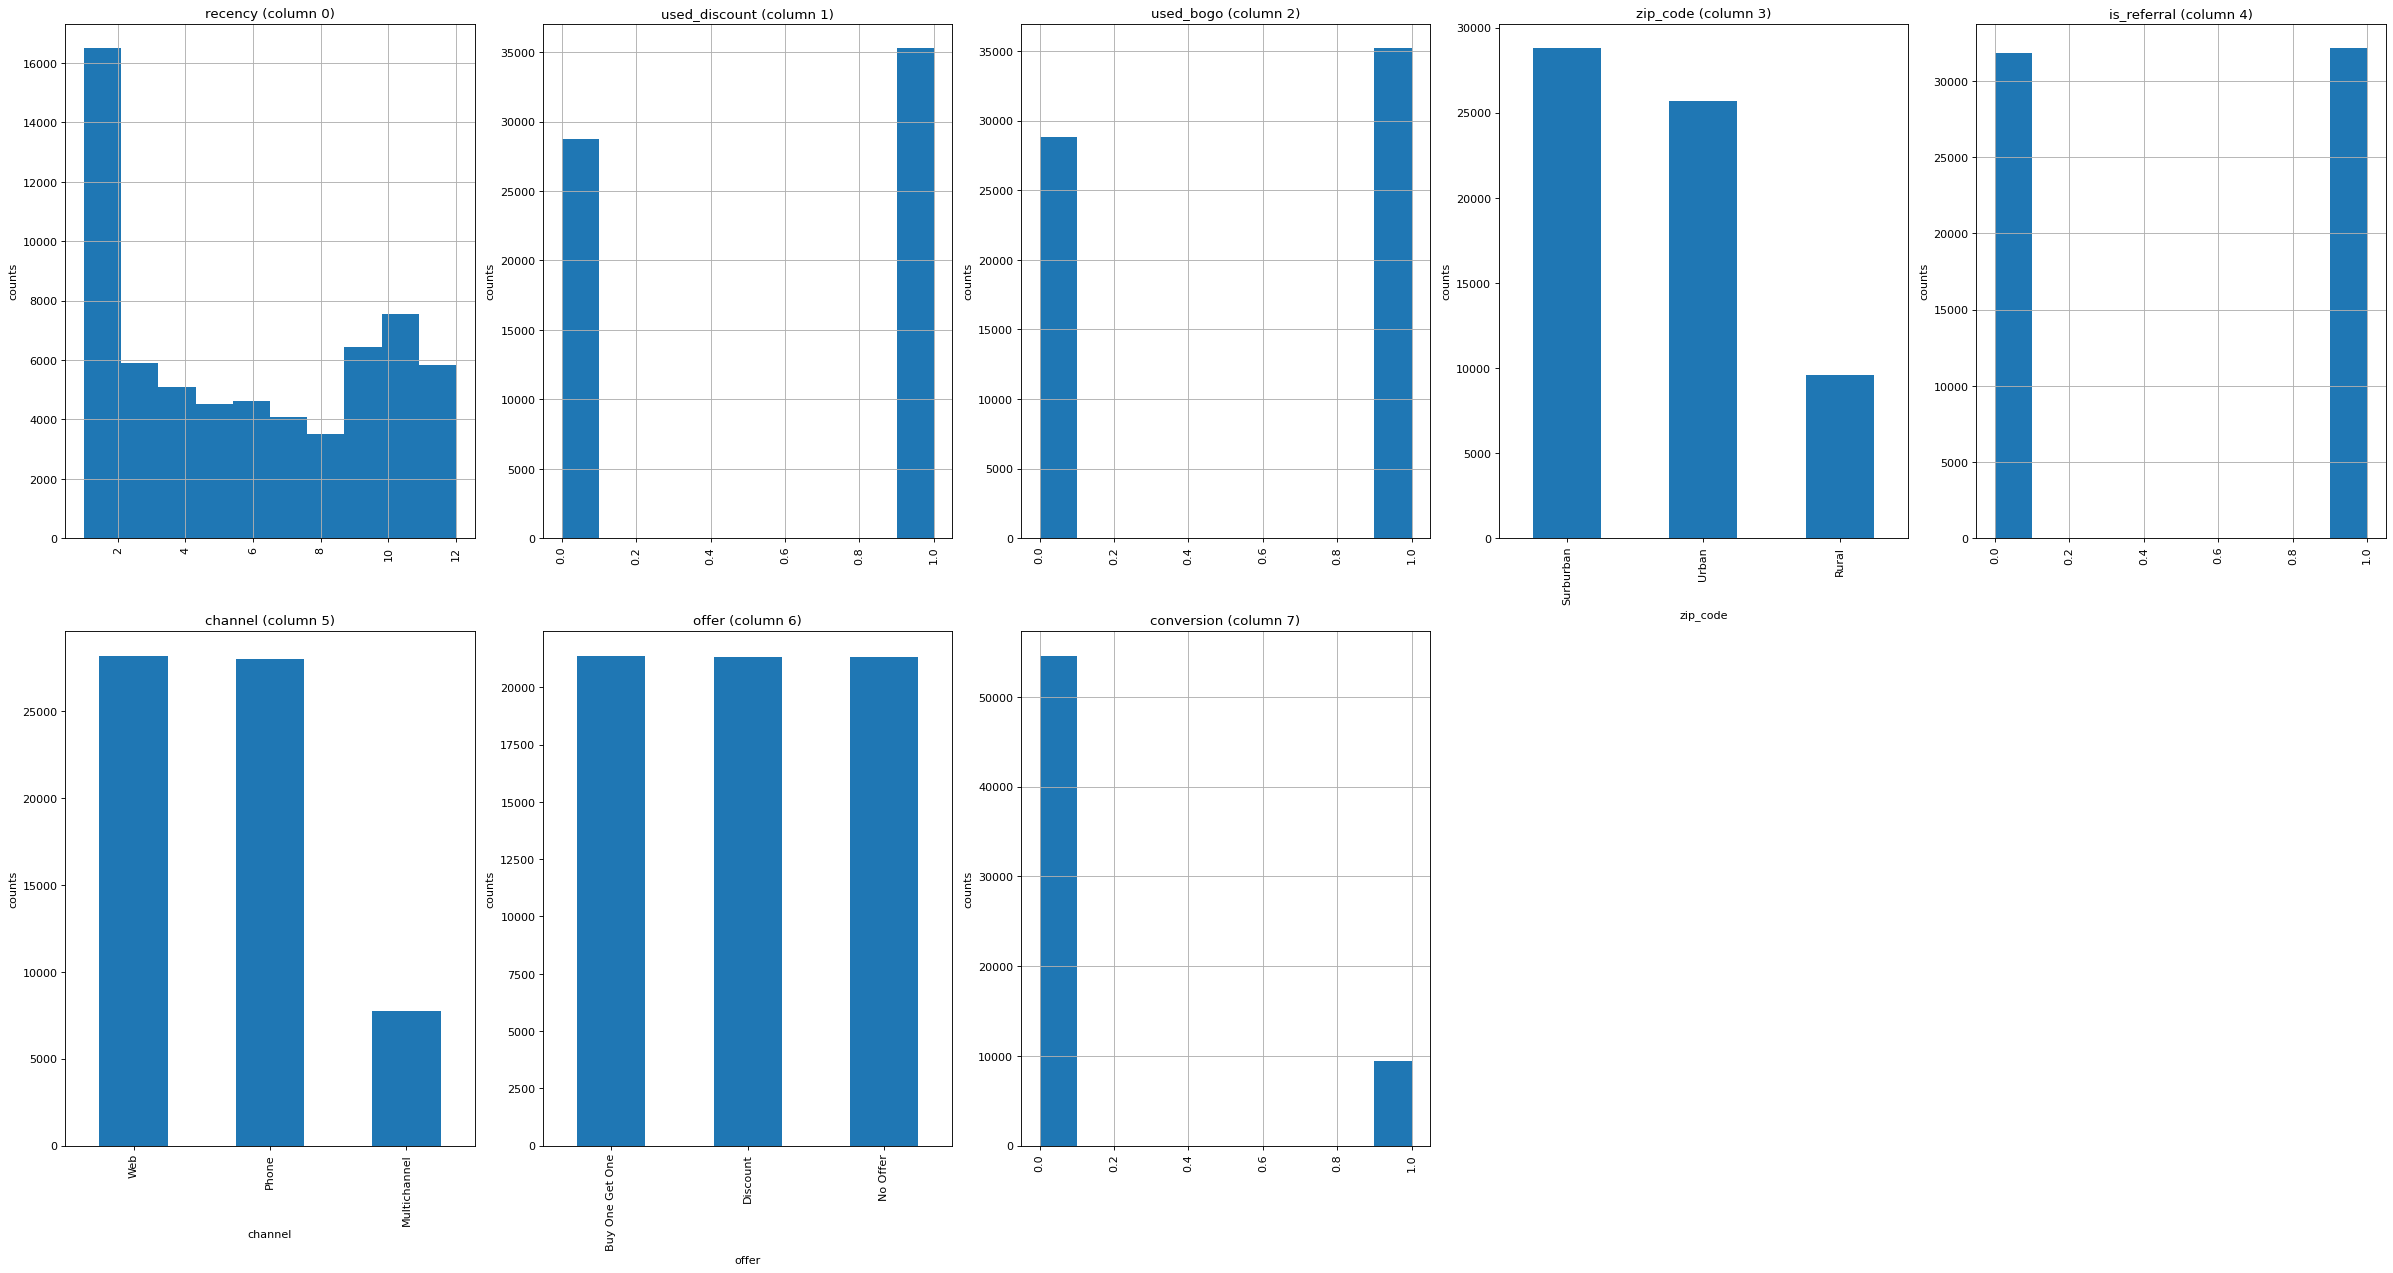

In [23]:
plotPerColumnDistribution(df, 10, 5)

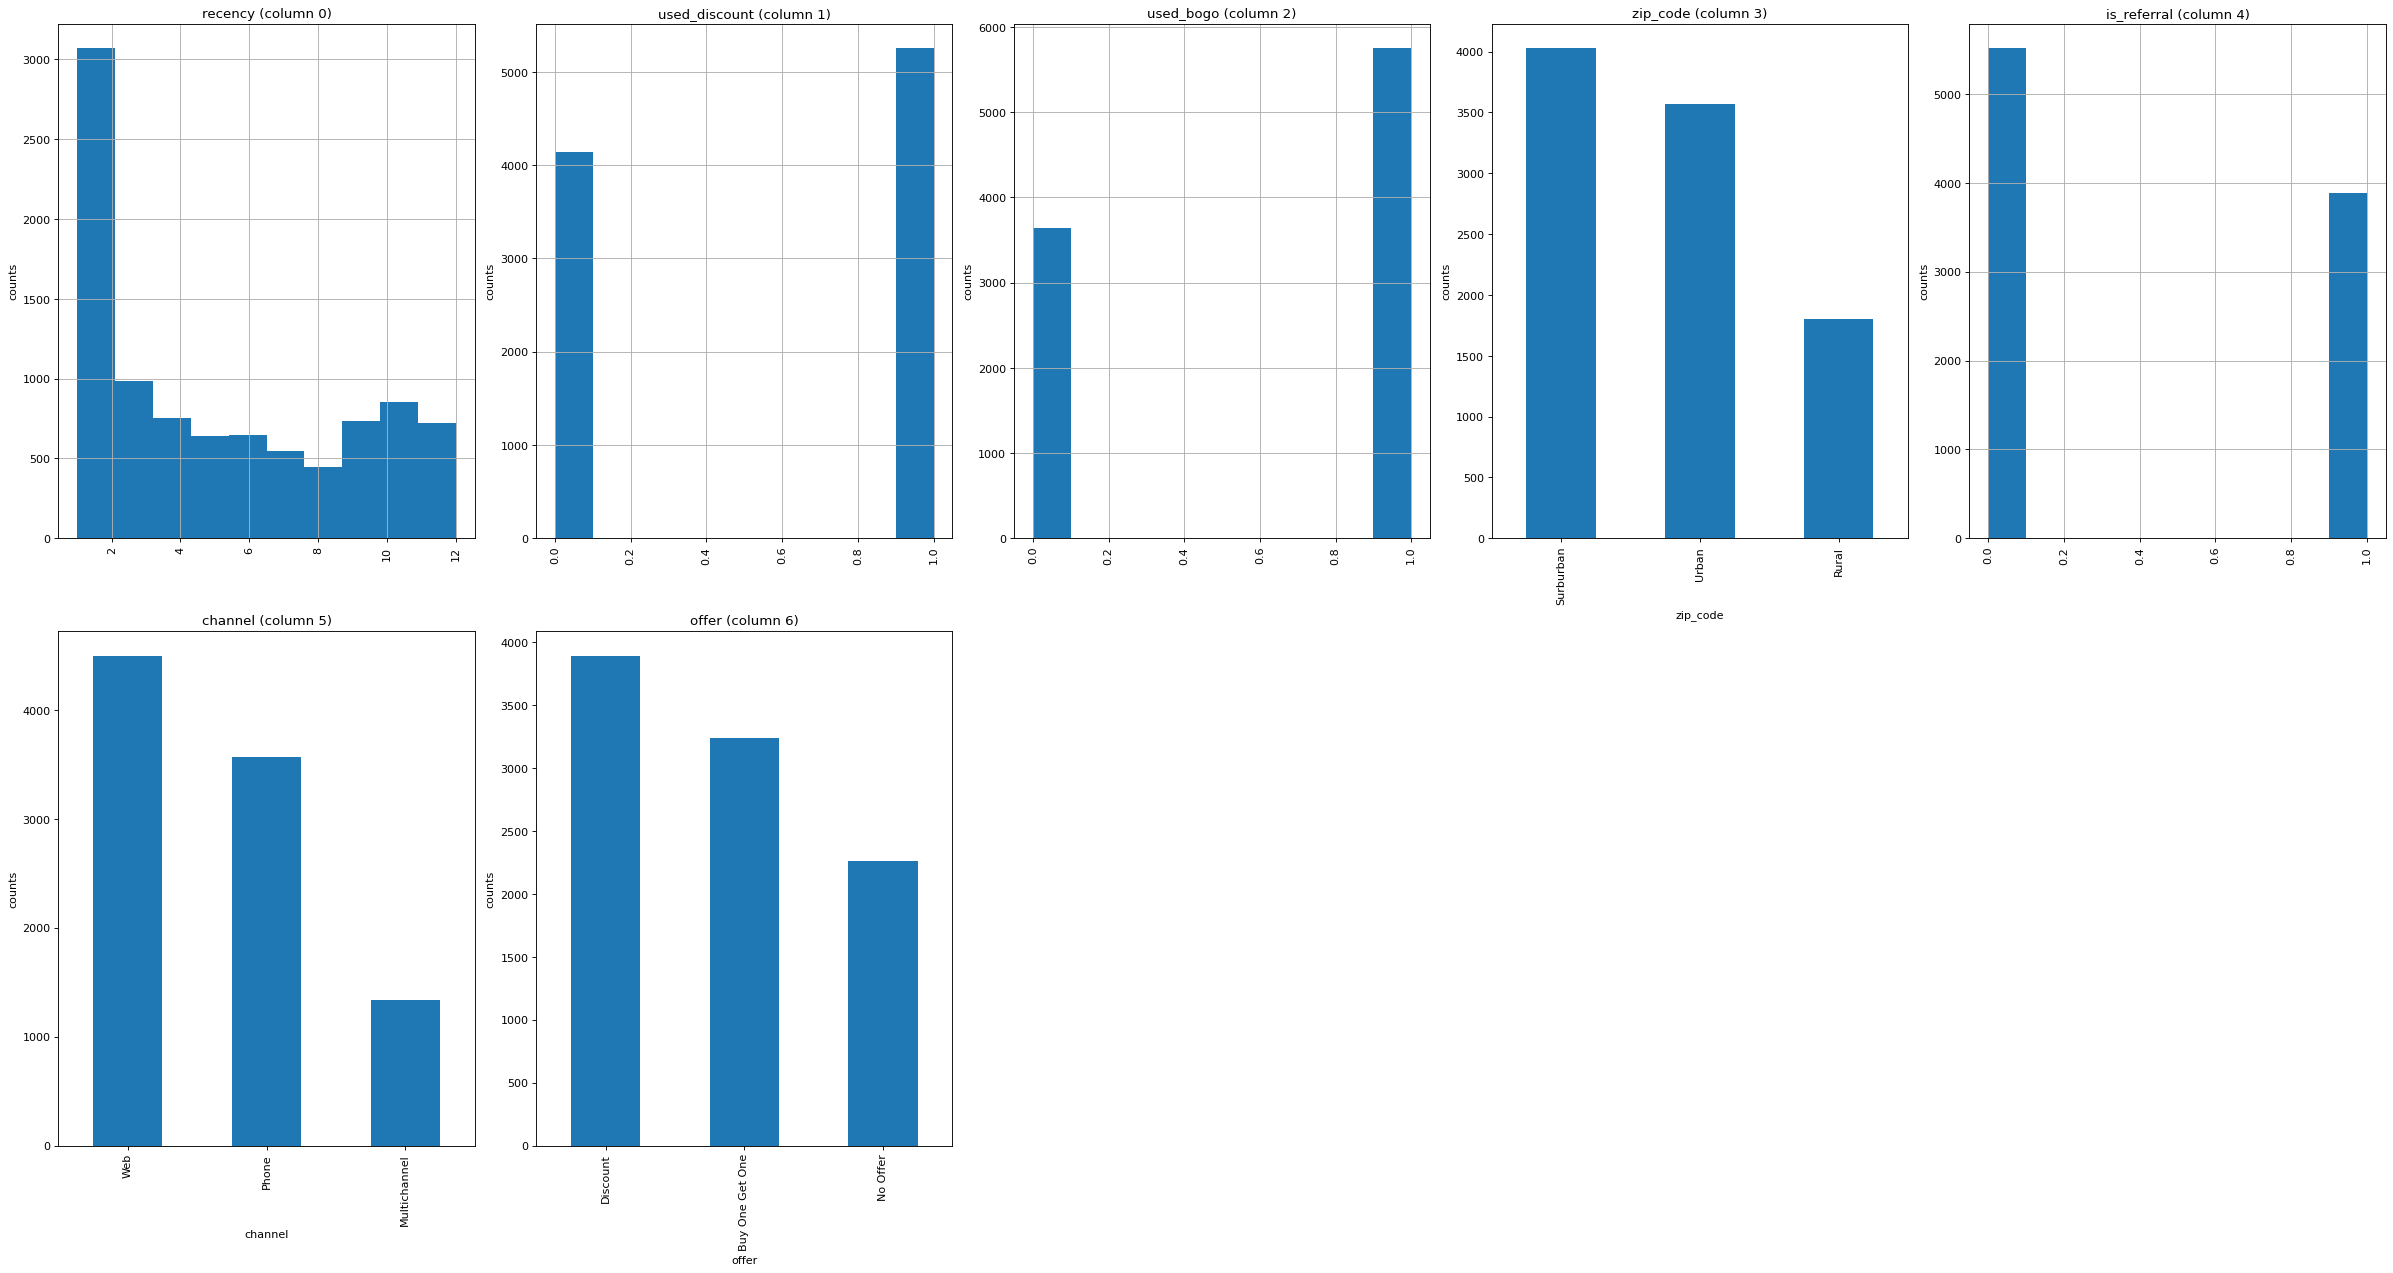

In [41]:
df1 = df.loc[df['conversion'] == 1]
plotPerColumnDistribution(df1, 10, 5)

In [31]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

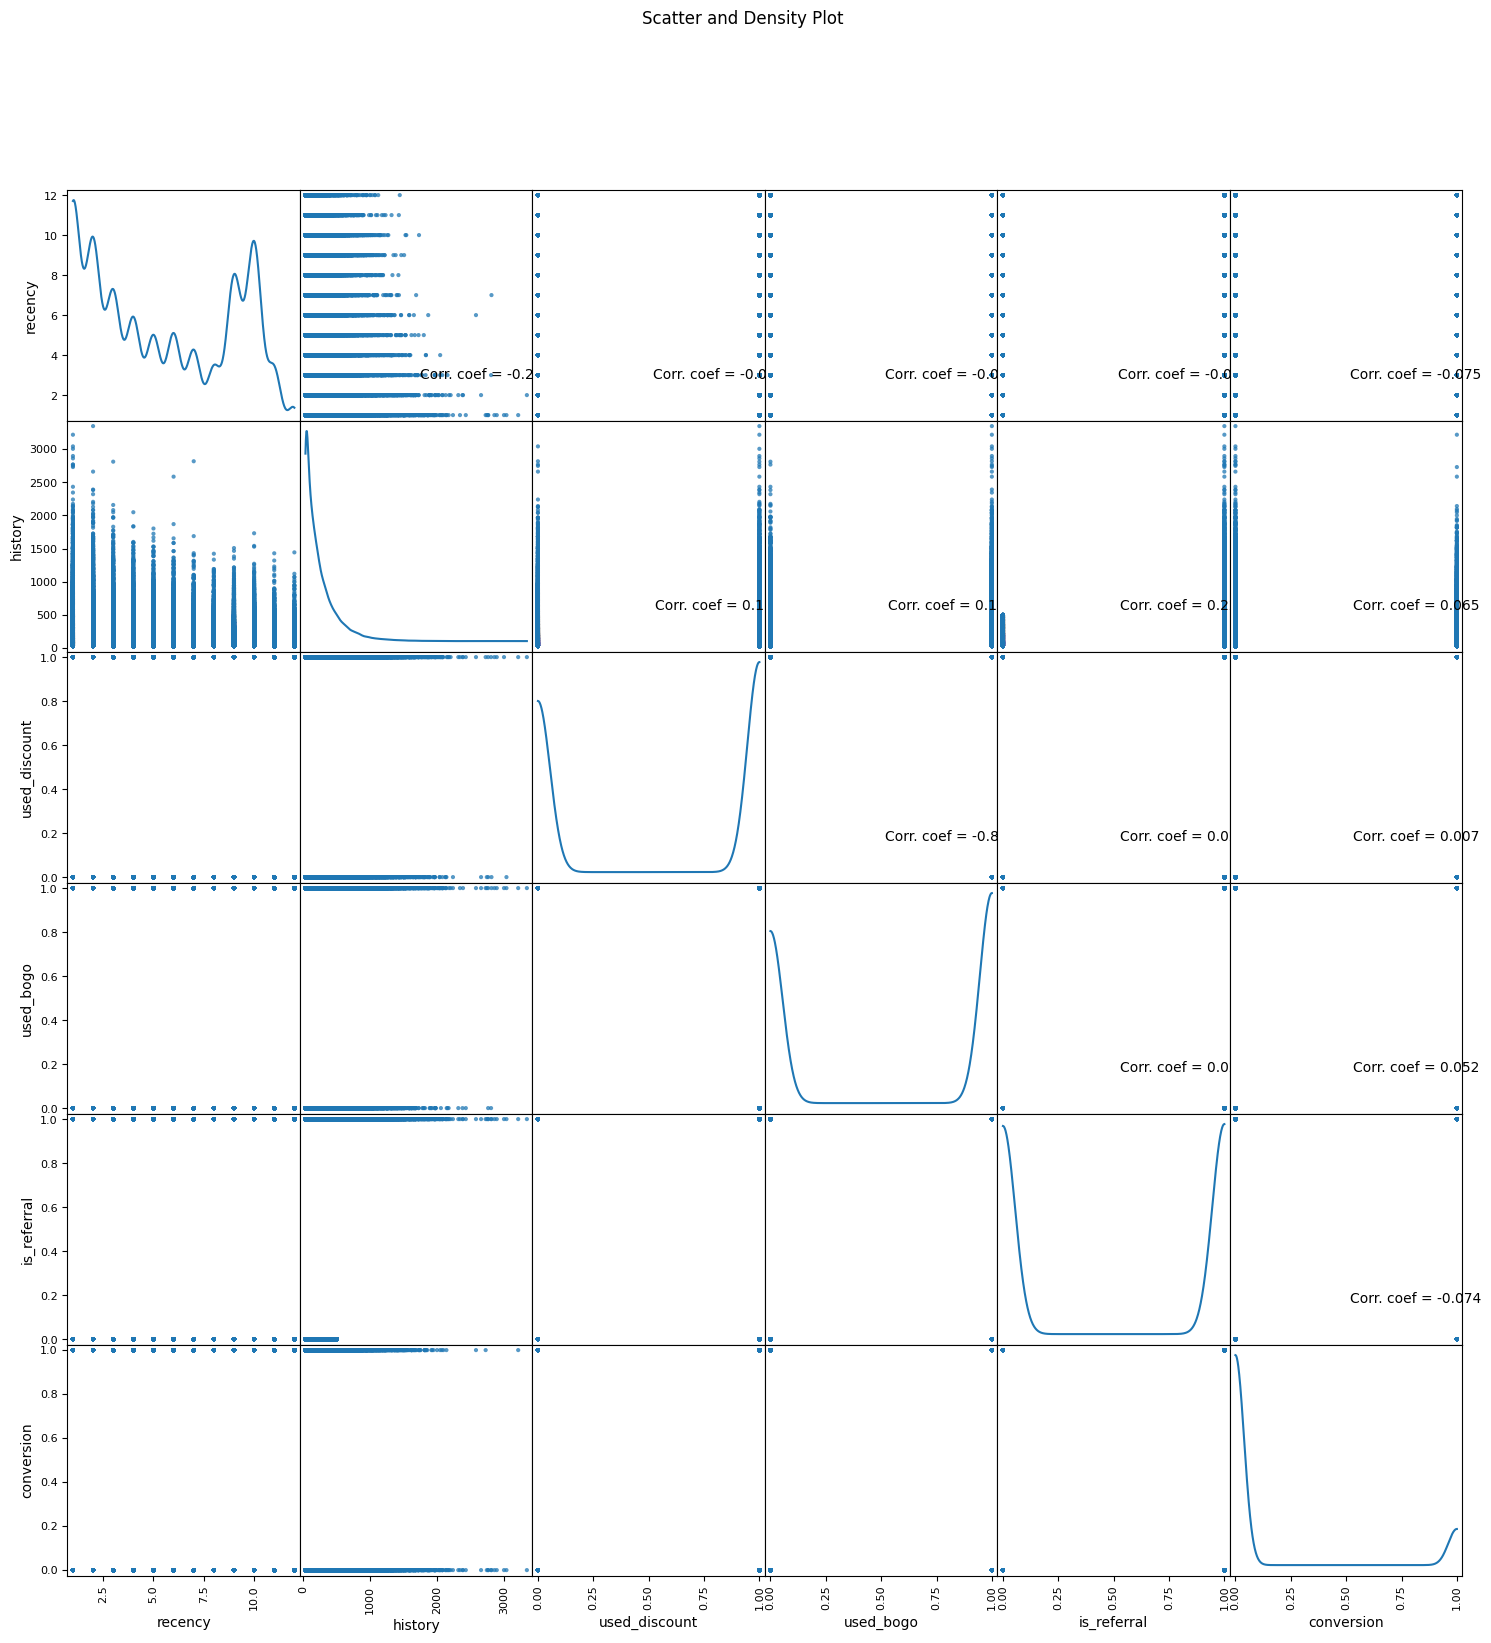

In [32]:
plotScatterMatrix(df, 18, 10)

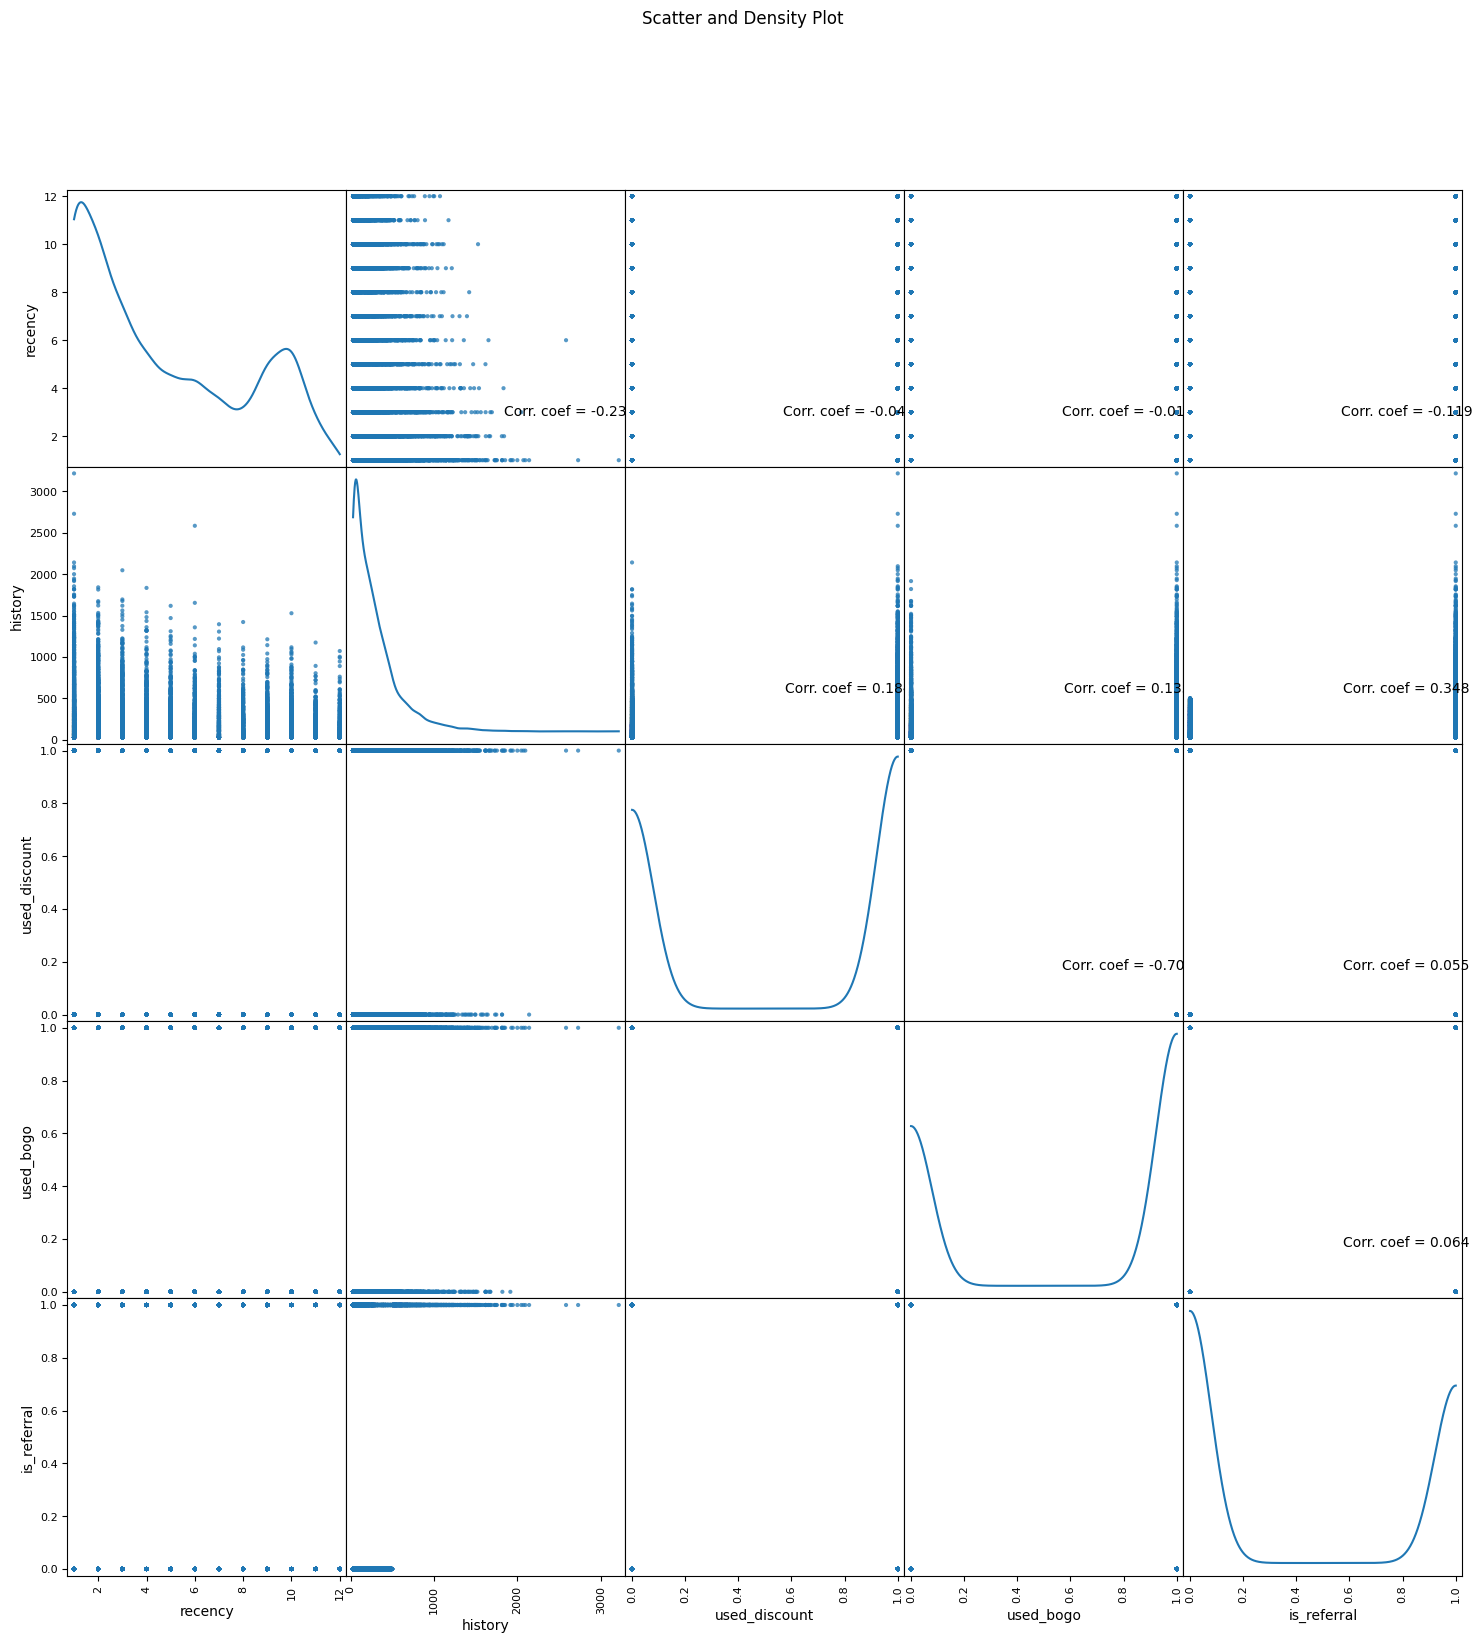

In [45]:
df1 = df.loc[df['conversion'] == 1]
plotScatterMatrix(df1, 18, 10)

In [39]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    name = "Customer conversion rate"
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    df['zip_code']=df['zip_code'].astype('category').cat.codes
    df['channel']=df['channel'].astype('category').cat.codes
    df['offer']=df['offer'].astype('category').cat.codes
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {name}', fontsize=15)
    plt.show()

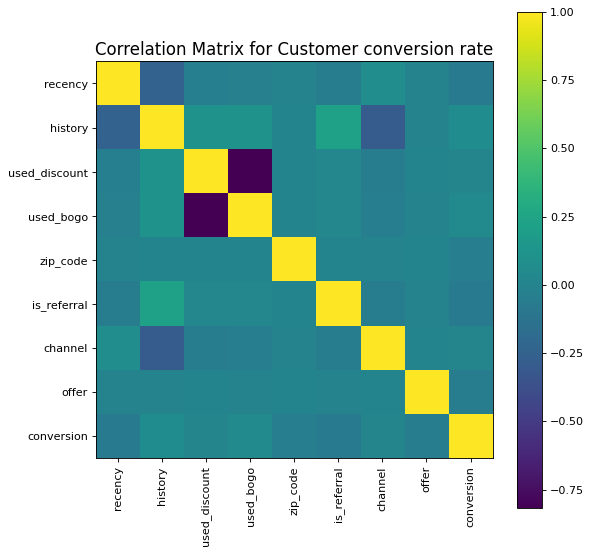

In [40]:
plotCorrelationMatrix(df, 8)

/tmp/ipykernel_2100/2459091286.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zip_code']=df['zip_code'].astype('category').cat.codes
/tmp/ipykernel_2100/2459091286.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['channel']=df['channel'].astype('category').cat.codes
/tmp/ipykernel_2100/2459091286.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

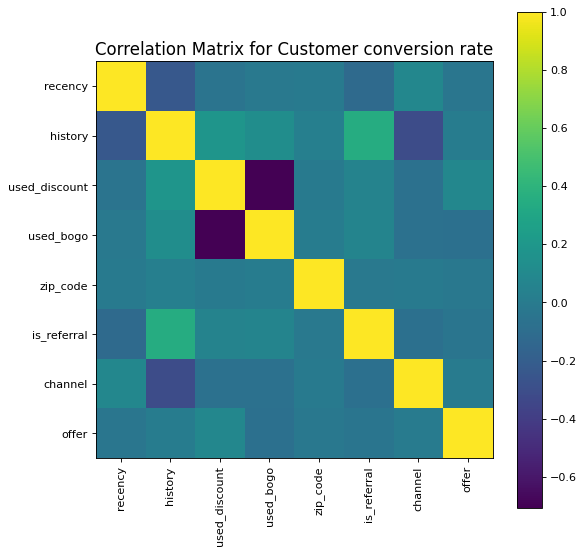

In [44]:
df1 = df.loc[df['conversion'] == 1]
plotCorrelationMatrix(df1,8)

Axes(0.125,0.11;0.775x0.77)


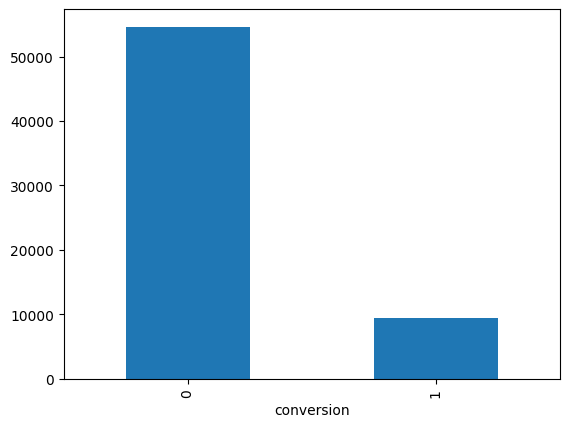

In [10]:
print(df['conversion'].value_counts().plot(kind='bar'))

<Axes: xlabel='channel'>

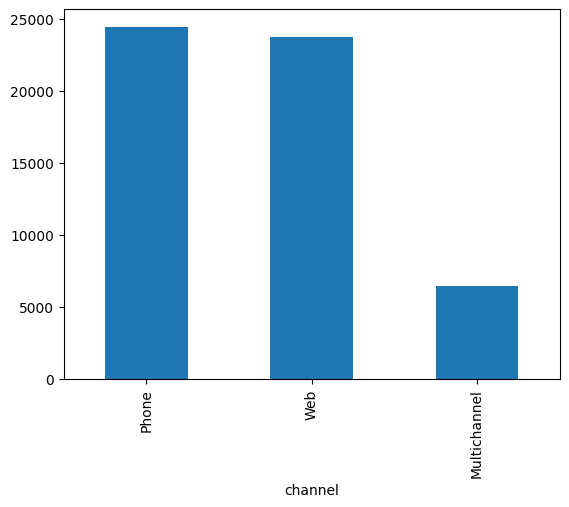

In [14]:
df['channel'][df['conversion'] == 0].value_counts().plot(kind='bar')

<Axes: xlabel='channel'>

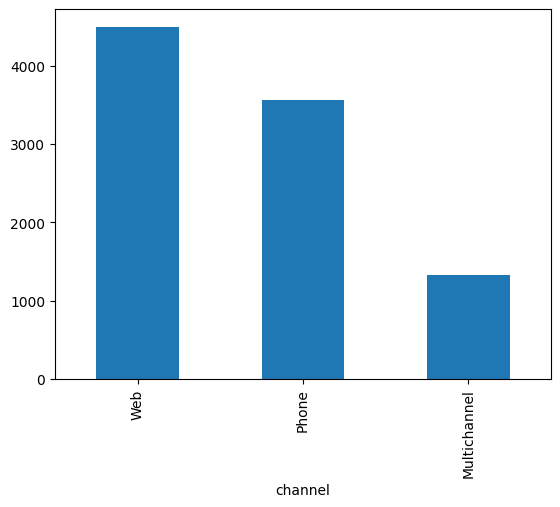

In [15]:
df['channel'][df['conversion'] == 1].value_counts().plot(kind='bar')

<Axes: xlabel='zip_code'>

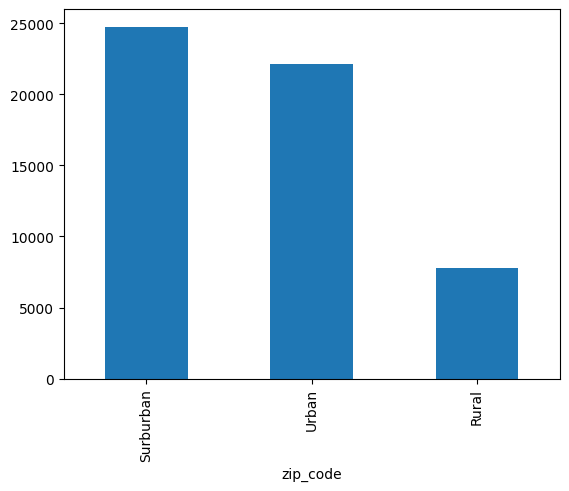

In [16]:
df['zip_code'][df['conversion'] == 0].value_counts().plot(kind='bar')

<Axes: xlabel='zip_code'>

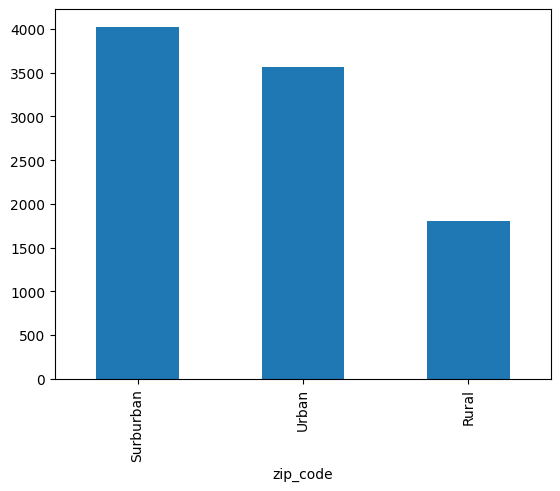

In [17]:
df['zip_code'][df['conversion'] == 1].value_counts().plot(kind='bar')

In [5]:
x_train = df.iloc[:,0:4]
y_train = df['conversion']
x_train,x_test, y_train, y_test = tts(x_train,y_train, test_size = 0.2, random_state = 10,stratify=df['conversion'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(51200, 4)
(12800, 4)
(51200,)
(12800,)


In [6]:
y_train.head()

1363     1
28778    0
30418    0
31898    0
63432    0
Name: conversion, dtype: int64

# Logistic Regression

In [23]:
y_train = np.array(y_train)

log_reg = LogisticRegression()
log_reg.fit(x_train,y_train.ravel())


LogisticRegression()

In [25]:
y_predict = log_reg.predict(x_test)
confusion_matrix(y_test, y_predict)
classification_report(y_test, y_predict)
target_names = ['0', '1']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Grid search Cross Validation

In [27]:
log_reg_param = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,C=c_values)
cv = RSF(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg_param, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/

In [28]:
y_predict_param = grid_result.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Conclusion
- Before hyperparameter tuning, the accuracy of the Logistic Regression model was 85\%. 
- After hyperparameter tuning, there was no change in the accuracy.

# Random forest

In [30]:
rand_for = RandomForestClassifier()
rand_for.fit(x_train,y_train.ravel())

RandomForestClassifier()

In [31]:
y_predict = rand_for.predict(x_test)
confusion_matrix(y_test, y_predict)
classification_report(y_test, y_predict)
target_names = ['0', '1']
print(classification_report(y_test, y_predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     10921
           1       0.17      0.15      0.16      1879

    accuracy                           0.77     12800
   macro avg       0.51      0.51      0.51     12800
weighted avg       0.76      0.77      0.76     12800



## Random Search CV

In [35]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
rand_for_param = RandomForestClassifier()
param = {'n_estimators': n_estimators,
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rand_search_random = RandomizedSearchCV(rand_for_param, param_distributions=param, n_iter=10, cv=5,n_jobs=-1)

rand_search_random.fit(x_train, y_train)
print("Accuracy ",rand_search_random.score(x_test, y_test))
print("Accuracy ",rand_search_random.score(x_train, y_train))

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To 

Accuracy  0.837734375
Accuracy  0.86763671875


In [36]:
y_predict_param = rand_search_random.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      0.98      0.91     10921
           1       0.18      0.03      0.05      1879

    accuracy                           0.84     12800
   macro avg       0.52      0.50      0.48     12800
weighted avg       0.75      0.84      0.78     12800



## Grid Search Cross validation

In [37]:
rf_gscv = RandomForestClassifier()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,C=c_values)
cv = RSF(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=log_reg_param, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train,y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:416: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/

In [39]:
y_predict_param = grid_search.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Conclusion
- Random forest, without any tuning, gives an accuracy of 86\%.
- Random forest, after randomized search cross validation gives an accuracy of 85\%.
- Random forest, after grid search cross validation also gives an accuracy of 85\%.
- This means that the random forest model, with the default parameters, gives us the best accuracy.

# SVM

In [10]:
svm = LinearSVC()
svm.fit(x_train, y_train.ravel())

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [11]:
y_predict_param = svm.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

## Grid Search cross validation


In [12]:
param_dist = {'C': np.logspace(-3, 3, 7),
              'max_iter': [10000],
              'tol': [1e-3, 1e-4, 1e-5]}

svm=LinearSVC()
grid_search_svm = GridSearchCV(svm, param_grid=param_dist, cv=10,n_jobs=-1)

grid_search_svm.fit(x_train, y_train)

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed 

GridSearchCV(cv=10, estimator=LinearSVC(), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'max_iter': [10000], 'tol': [0.001, 0.0001, 1e-05]})

In [13]:
y_predict_param = grid_search_svm.predict(x_test)
confusion_matrix(y_test, y_predict_param)
classification_report(y_test, y_predict_param )
target_names = ['0', '1']
print(classification_report(y_test, y_predict_param , target_names=target_names))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10921
           1       0.00      0.00      0.00      1879

    accuracy                           0.85     12800
   macro avg       0.43      0.50      0.46     12800
weighted avg       0.73      0.85      0.79     12800



/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/omar/ml/Retail/promo-on-customer-conversion-rate/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

# Uplift modeling

In [48]:
cat_features = [col for col in df.columns if df[col].dtype == 'object']
for c in cat_features:
    print('----')
    print(df[c].value_counts())

----
zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64
----
channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64
----
offer
Buy One Get One    21387
Discount           21307
No Offer           21306
Name: count, dtype: int64


In [58]:
def plotCatVarDistribution(df):
    plt.rcParams['figure.dpi'] = 600
    fig = plt.figure(figsize=(6, 6), facecolor='#f6f5f5')
    gs = fig.add_gridspec(3, 3)
    gs.update(wspace=0.3, hspace=0.3)

    background_color = "#f6f5f5"
    sns.set_palette(['#99d6e6']*3)

    run_no = 0
    for row in range(0, 1):
        for col in range(0, 3):
            locals()["ax"+str(run_no)] = fig.add_subplot(gs[row, col])
            locals()["ax"+str(run_no)].set_facecolor(background_color)
            for s in ["top","right"]:
                locals()["ax"+str(run_no)].spines[s].set_visible(False)
            run_no += 1

    ax0.text(-0.5, 55, 'Categorical Variable Distribution', fontsize=6, fontweight='bold')
    # ax0.text(-0.5, 60, 'features_25 - features_49', fontsize=6, fontweight='light')        

    run_no = 0
    for col in cat_features:
        temp_df = pd.DataFrame(df[col].value_counts())
        temp_df = temp_df.reset_index(drop=False)
        temp_df.columns = ['Number', 'Count']
        sns.barplot(ax=locals()["ax"+str(run_no)],x=temp_df['Number'], y=temp_df['Count']/len(df)*100, zorder=2, linewidth=0, alpha=1, saturation=1)
        locals()["ax"+str(run_no)].grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(run_no)].grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
        locals()["ax"+str(run_no)].set_ylabel('')
        locals()["ax"+str(run_no)].set_xlabel(col, fontsize=4, fontweight='bold')
        locals()["ax"+str(run_no)].tick_params(labelsize=4, width=0.5, length=1.5)
        locals()["ax"+str(run_no)].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
        # data label
        for p in locals()["ax"+str(run_no)].patches:
            percentage = f'{p.get_height():.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            locals()["ax"+str(run_no)].text(x, y, percentage, ha='center', va='center', fontsize=4)

        run_no += 1

    plt.show()

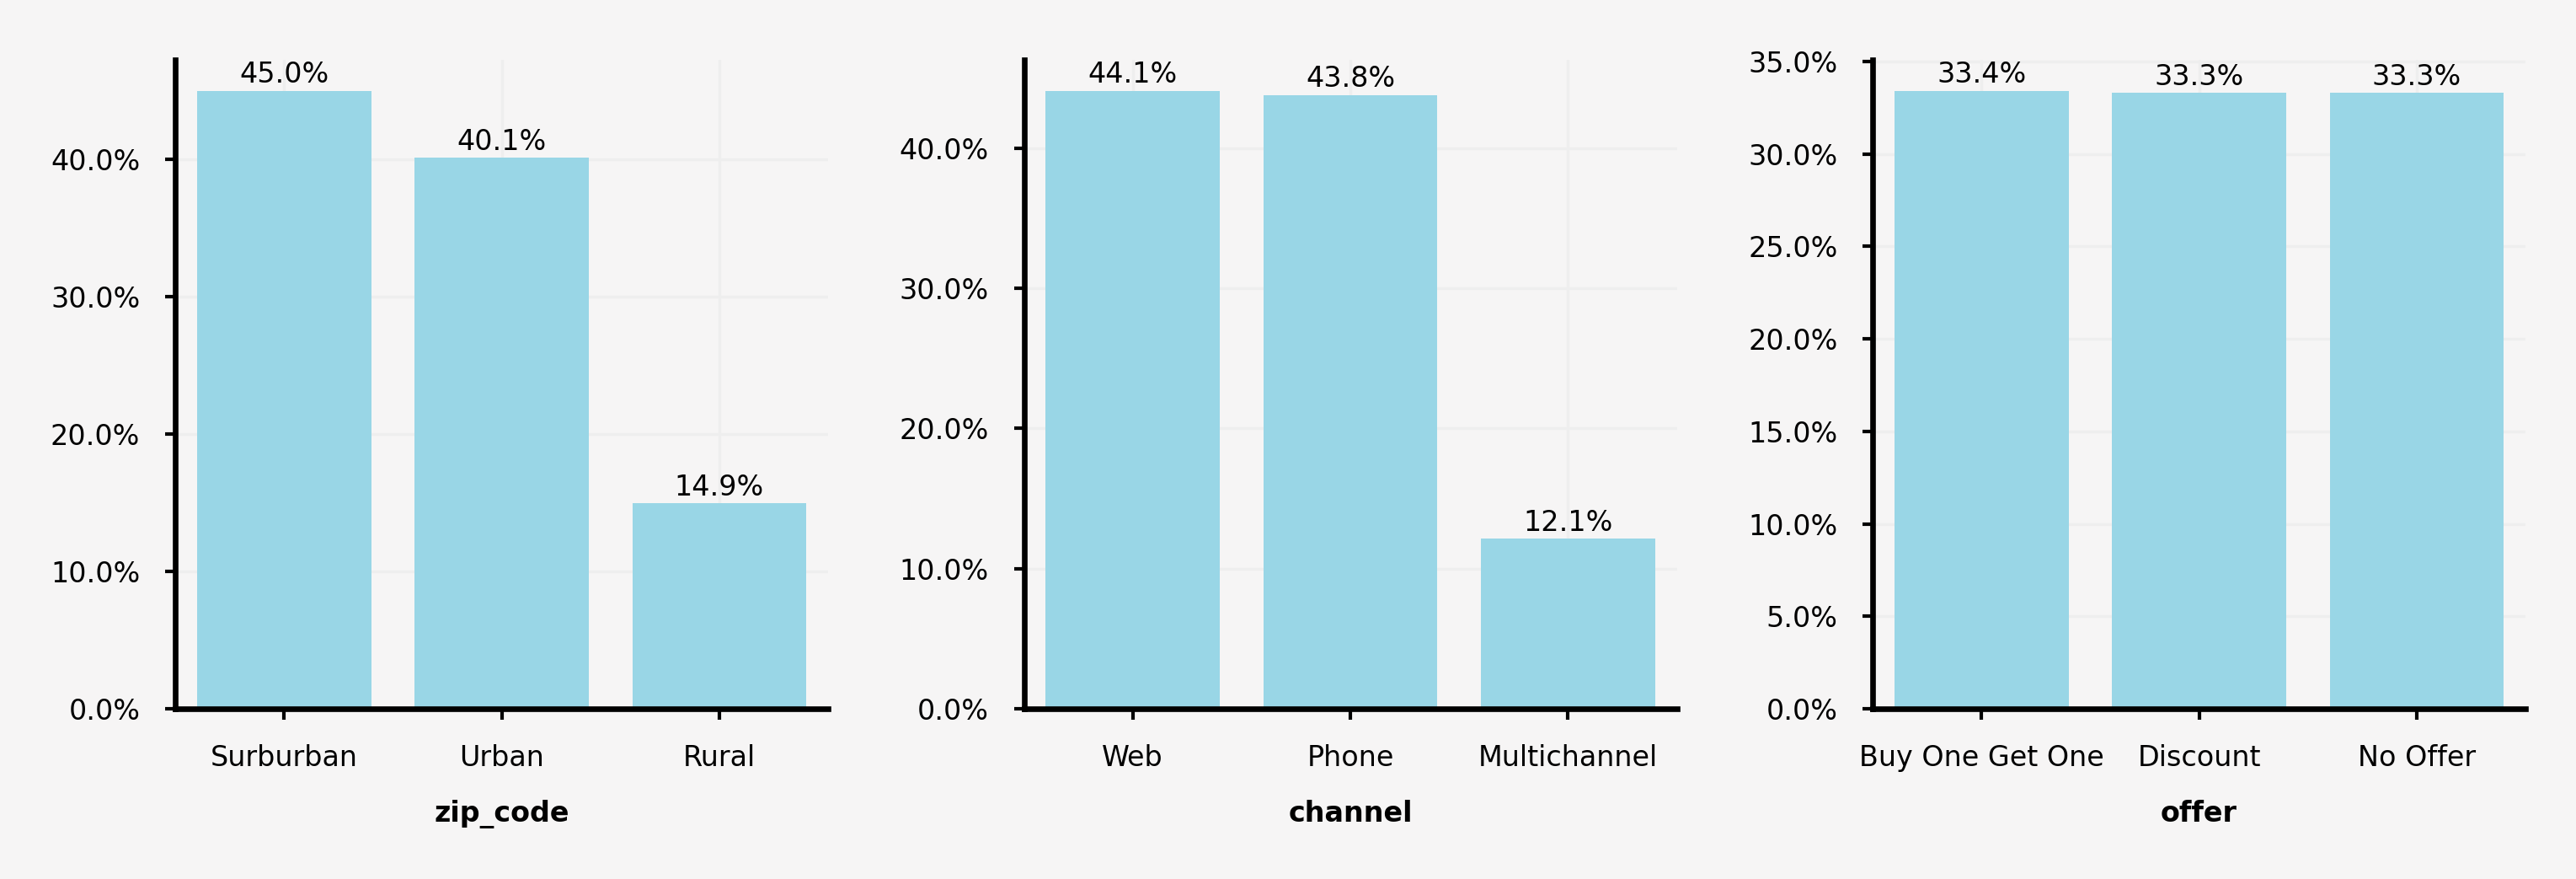

In [59]:
plotCatVarDistribution(df)

In [4]:
# Rename target column
df = df.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df = df.rename(columns={'offer': 'treatment'})
df.treatment = df.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

In [6]:
df.treatment.value_counts()

treatment
-1    21387
 1    21307
 0    21306
Name: count, dtype: int64

In [7]:
df.target.value_counts()

target
0    54606
1     9394
Name: count, dtype: int64

In [9]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,-1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,-1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,-1,0


In [11]:
df = pd.get_dummies(df)
df.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,False,True,False,False,True,False
1,6,329.08,1,1,1,0,0,True,False,False,False,False,True
2,7,180.65,0,1,1,-1,0,False,True,False,False,False,True
3,9,675.83,1,0,1,1,0,True,False,False,False,False,True
4,2,45.34,1,0,0,-1,0,False,False,True,False,False,True


In [12]:
df.mean()

recency                   5.763734
history                 242.085656
used_discount             0.551031
used_bogo                 0.549719
is_referral               0.502250
treatment                -0.001250
target                    0.146781
zip_code_Rural            0.149422
zip_code_Surburban        0.449625
zip_code_Urban            0.400953
channel_Multichannel      0.121281
channel_Phone             0.437828
channel_Web               0.440891
dtype: float64

In [13]:
df_bogo = df[df.treatment <= 0] # include no offer, bogo
df_discount = df[df.treatment >= 0] # include no offer, discount

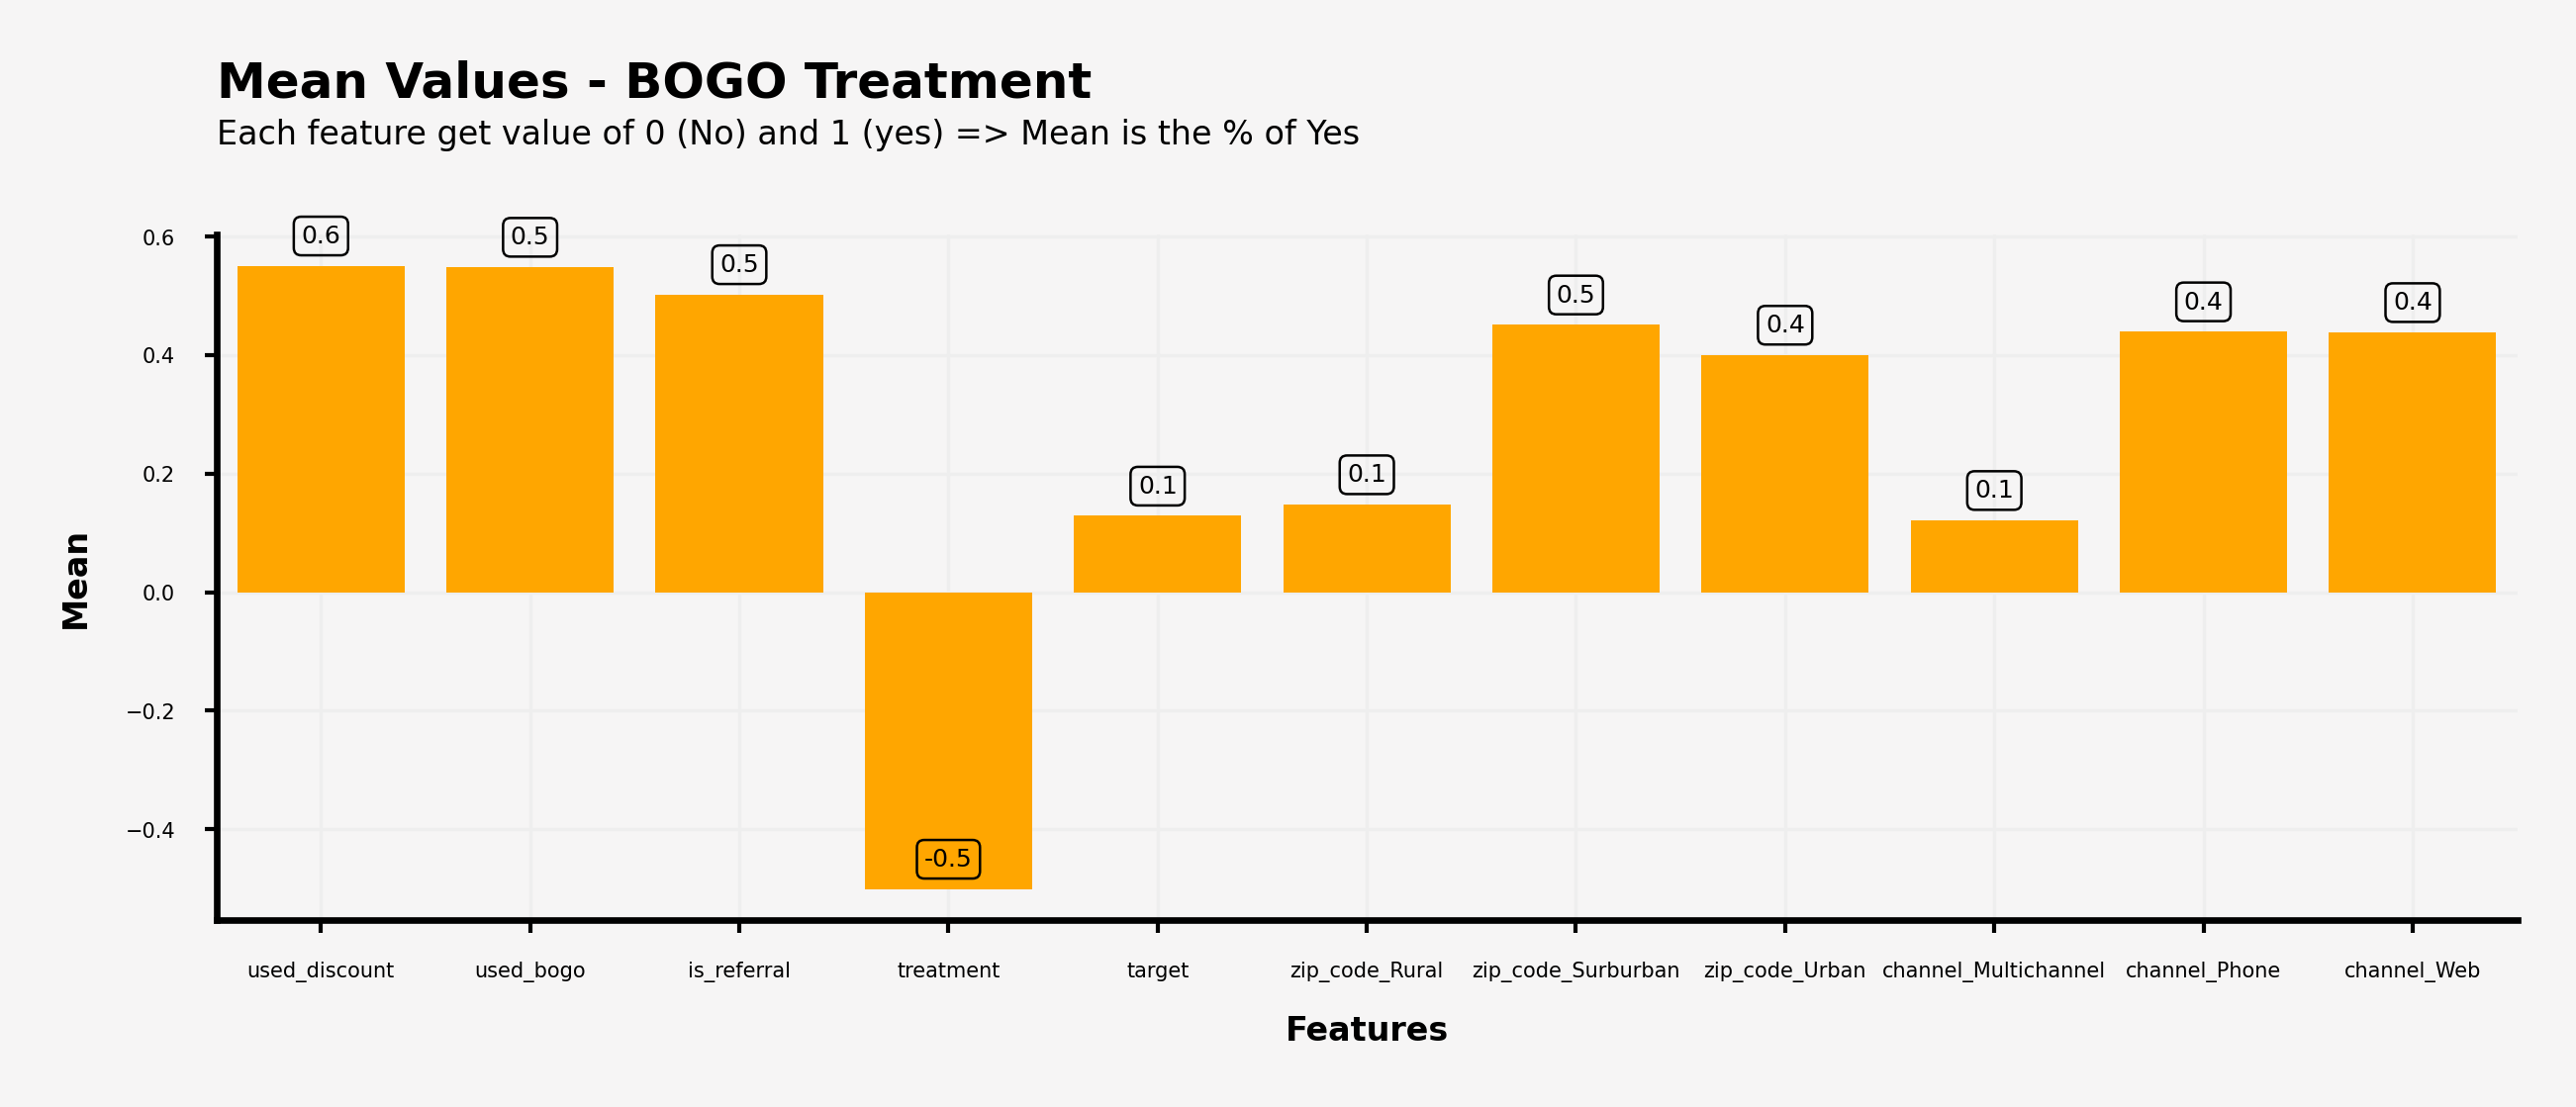

In [18]:
temp_df = df_bogo.mean()
temp_df = temp_df.reset_index(drop=False)
temp_df.columns = ['Features', 'Mean']
temp_df = temp_df.iloc[2:,:]
#temp_df = temp_df.sort_values('Mean', ascending=False)

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(5, 1.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.1)

background_color = "#f6f5f5"
sns.set_palette(['#ffa600']*11)

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)
ax_sns = sns.barplot(ax=ax, x=temp_df['Features'], 
                      y=temp_df['Mean'], 
                      zorder=2, linewidth=0, alpha=1, saturation=1)
ax_sns.set_xlabel("Features",fontsize=4, weight='bold')
ax_sns.set_ylabel("Mean",fontsize=4, weight='bold')
ax_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.tick_params(labelsize=2.5, width=0.5, length=1.5)
ax.text(-0.5, 0.9, 'Mean Values - BOGO Treatment', fontsize=6, ha='left', va='top', weight='bold')
ax.text(-0.5, 0.8, 'Each feature get value of 0 (No) and 1 (yes) => Mean is the % of Yes', fontsize=4, ha='left', va='top')
# data label
for p in ax.patches:
    percentage = f'{p.get_height():.1f}' ##{:. 0%}
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.05
    ax.text(x, y, percentage, ha='center', va='center', fontsize=3,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

plt.show()

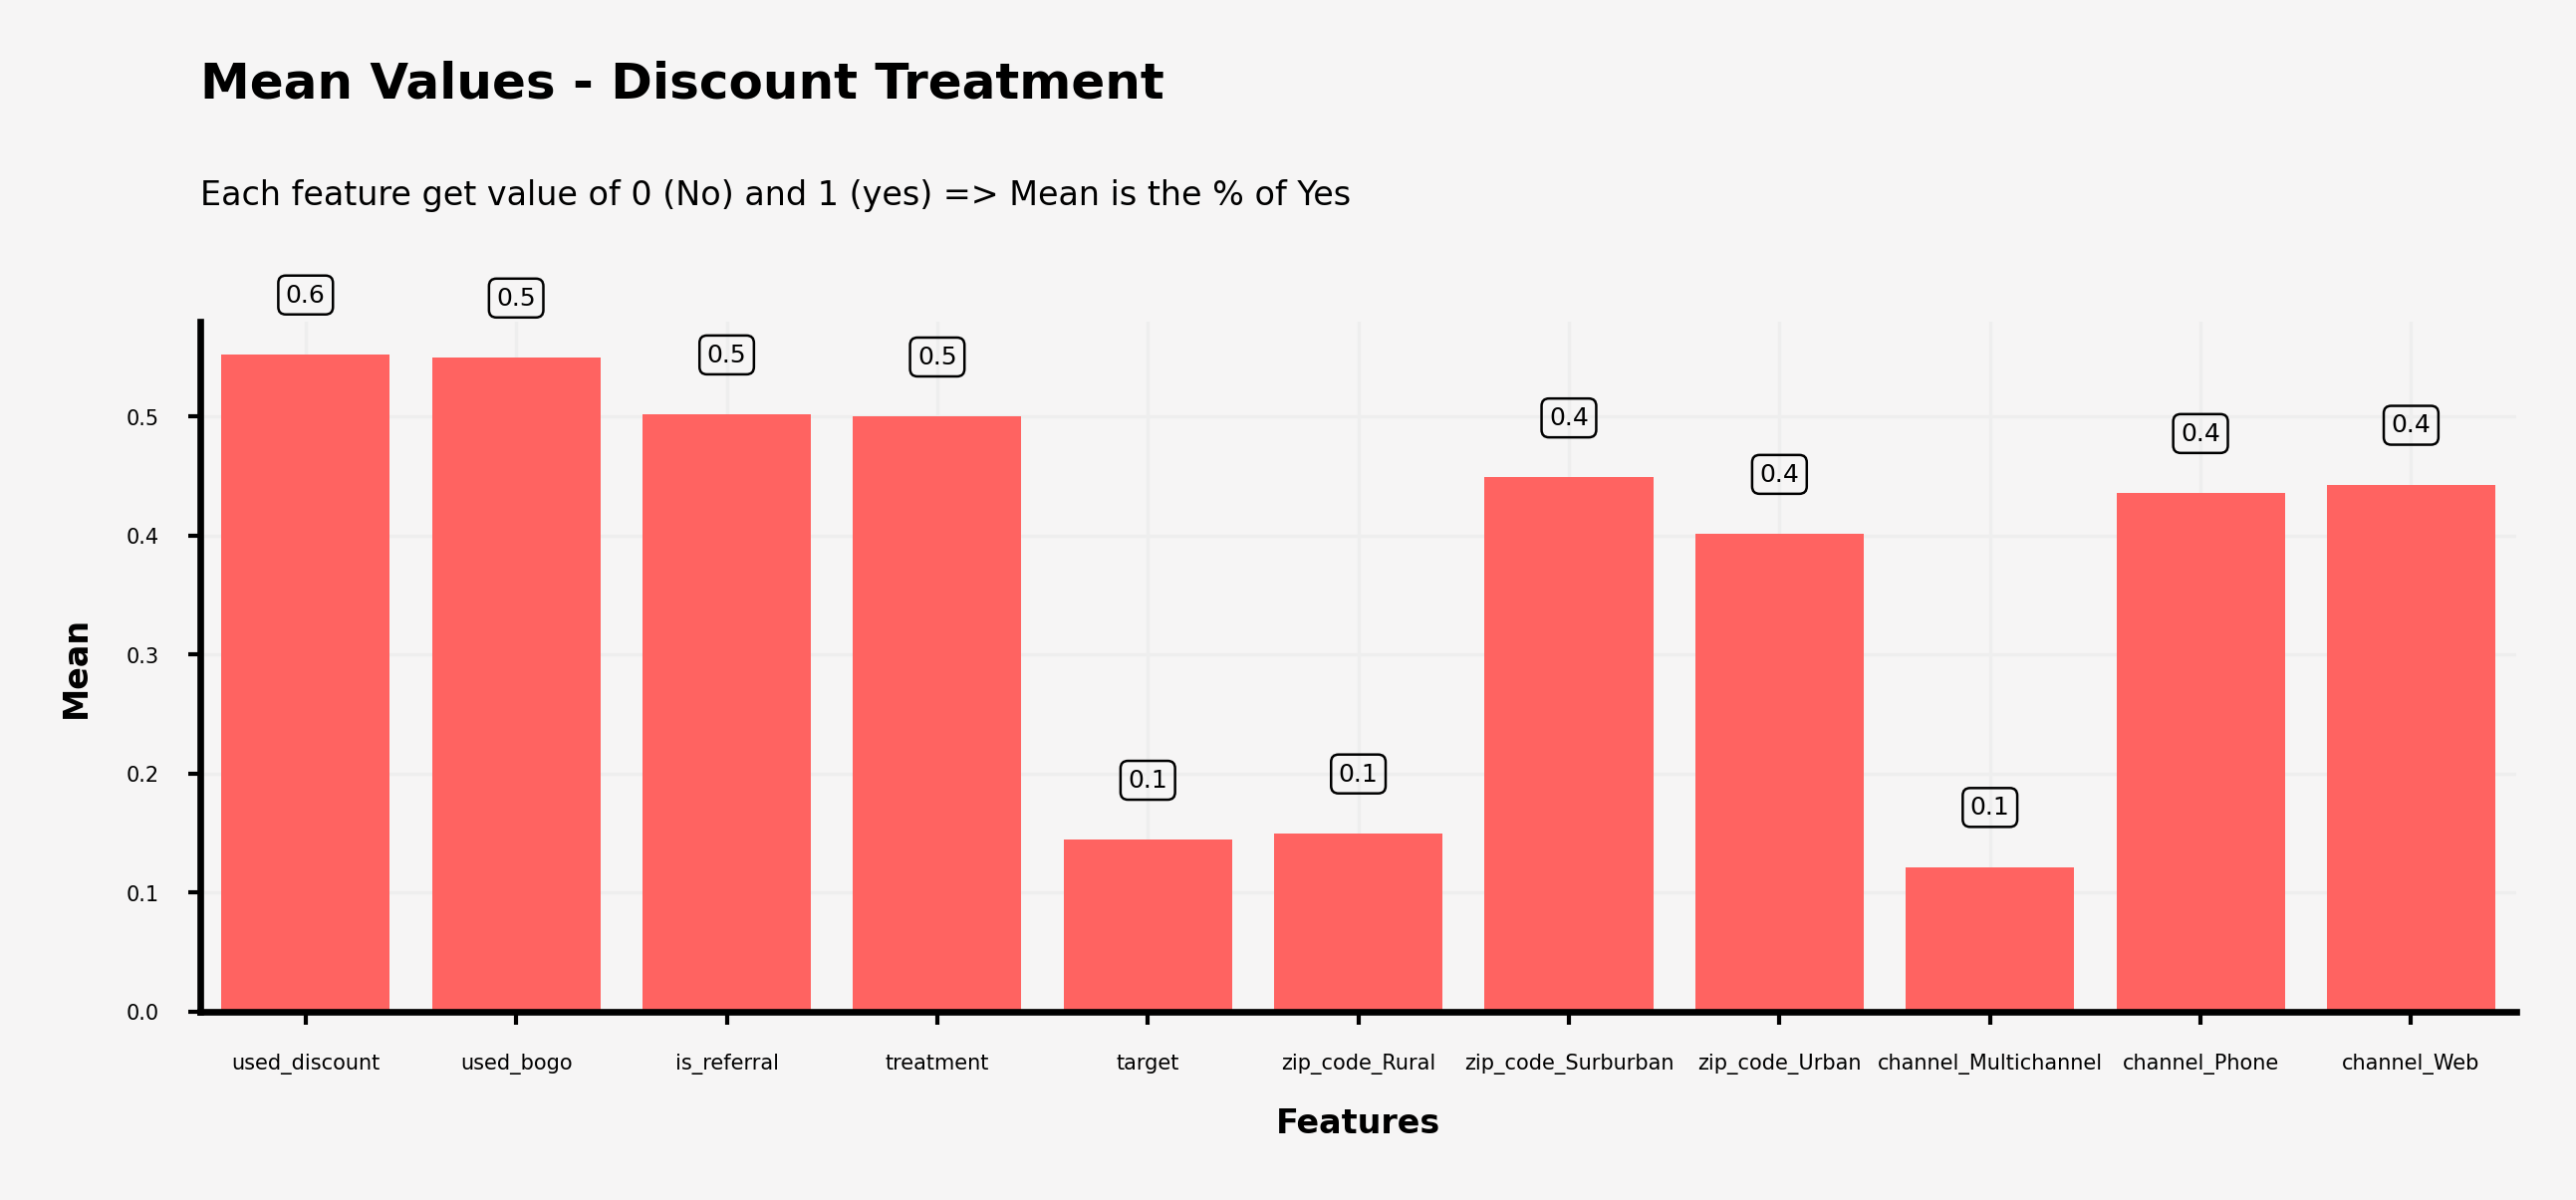

In [21]:
temp_df = df_discount.mean()
temp_df = temp_df.reset_index(drop=False)
temp_df.columns = ['Features', 'Mean']
temp_df = temp_df.iloc[2:,:]
#temp_df = temp_df.sort_values('Mean', ascending=False)

plt.rcParams['figure.dpi'] = 600
fig = plt.figure(figsize=(5, 1.5), facecolor='#f6f5f5')
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.4, hspace=0.1)

background_color = "#f6f5f5"
sns.set_palette(['#ff6361']*11)

ax = fig.add_subplot(gs[0, 0])
for s in ["right", "top"]:
    ax.spines[s].set_visible(False)
ax.set_facecolor(background_color)
ax_sns = sns.barplot(ax=ax, x=temp_df['Features'], 
                      y=temp_df['Mean'], 
                      zorder=2, linewidth=0, alpha=1, saturation=1)
ax_sns.set_xlabel("Features",fontsize=4, weight='bold')
ax_sns.set_ylabel("Mean",fontsize=4, weight='bold')
ax_sns.grid(which='major', axis='x', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.grid(which='major', axis='y', zorder=0, color='#EEEEEE', linewidth=0.4)
ax_sns.tick_params(labelsize=2.5, width=0.5, length=1.5)
ax.text(-0.5, 0.8, 'Mean Values - Discount Treatment', fontsize=6, ha='left', va='top', weight='bold')
ax.text(-0.5, 0.7, 'Each feature get value of 0 (No) and 1 (yes) => Mean is the % of Yes', fontsize=4, ha='left', va='top')
# data label
for p in ax.patches:
    percentage = f'{p.get_height():.1f}' ##{:. 0%}
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.05
    ax.text(x, y, percentage, ha='center', va='center', fontsize=3,
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.3))

plt.show()

In [28]:
def declare_tc(dataframe:pd.DataFrame):
    dataframe['target_class'] = 0
    dataframe.loc[(dataframe.treatment == 0) & (dataframe.target != 0),'target_class'] = 1 # CR
    dataframe.loc[(dataframe.treatment != 0) & (dataframe.target == 0),'target_class'] = 2 # TN
    dataframe.loc[(dataframe.treatment != 0) & (dataframe.target != 0),'target_class'] = 3 # TR
    return dataframe

In [29]:
df_bogo = declare_tc(df_bogo)
df_discount = declare_tc(df_discount)

/tmp/ipykernel_22339/724079300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['target_class'] = 0


In [30]:
df_bogo['target_class'].value_counts()

target_class
0    19044
2    18149
3     3238
1     2262
Name: count, dtype: int64

In [66]:
def uplift_split(df:pd.DataFrame):
    ## 1 - Train-Test Split
    x = df.drop(['target','target_class'],axis=1)
    y = df.target_class
    x_train, x_test, y_train, y_test  = train_test_split(x, y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df['treatment'])
    return x_train,x_test, y_train, y_test


In [67]:
def uplift_model(x_train:pd.DataFrame,
                 x_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    ## 2 - Using XGB to get the uplift score
    # Create new dataframe
    result = pd.DataFrame(x_test).copy()    
    # Fit the model
    uplift_model = xgb.XGBClassifier().fit(x_train.drop('treatment', axis=1), y_train)
    
    
    # Predict using test-data
    uplift_proba = uplift_model.predict_proba(x_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result

In [68]:
def uplift(df:pd.DataFrame):
    # Combine the split and Modeling function
    x_train, x_test, y_train, y_test = uplift_split(df)
    result = uplift_model(x_train, x_test, y_train, y_test)
    return result

In [69]:
bogo_uplift = uplift(df_bogo)
discount_uplift = uplift(df_discount)

In [70]:
bogo_uplift.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
31024,10,211.48,1,0,0,0,False,True,False,True,False,False,0.623754,0.057602,0.273621,0.045023,0.113510,1
10728,10,140.50,1,0,0,-1,False,False,True,False,True,False,0.511970,0.019497,0.440900,0.027633,0.044586,2
9555,4,76.25,1,0,0,-1,False,True,False,False,True,False,0.468098,0.090066,0.381348,0.060488,-0.048920,2
48906,5,29.99,0,1,0,-1,True,False,False,False,True,False,0.461972,0.092152,0.331452,0.114424,0.180654,2
36219,9,248.28,1,0,0,-1,False,True,False,False,False,True,0.512261,0.076322,0.368803,0.042614,-0.052184,3


In [79]:
df2 = pd.read_csv('data.csv')
seg_df = df2.merge(bogo_uplift.iloc[:,-6:], left_index=True, right_index=True)
seg_df['target'] = 0
seg_df.head()
seg_df['target'][seg_df.offer != 'No Offer'] = 1

/tmp/ipykernel_22339/2968292068.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df['target'][seg_df.offer != 'No Offer'] = 1


In [ ]:
def qini_rank(uplift:pd.DataFrame):
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked

In [ ]:
# evaluate the qini model
def qini_eval(ranked:pd.DataFrame):
    uplift_model, random_model = ranked.copy(), ranked.copy()
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged

In [ ]:
# plot the data
def qini_plot(merged:pd.DataFrame):
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged, style='model', palette=['red','grey'])
    sns.set_style('ticks')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=5)
    plt.ylabel('Uplift',fontsize=5)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=5)
    ax.tick_params(labelsize=5)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax

In [82]:
# combine all the functions
def qini(uplift:pd.DataFrame):
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

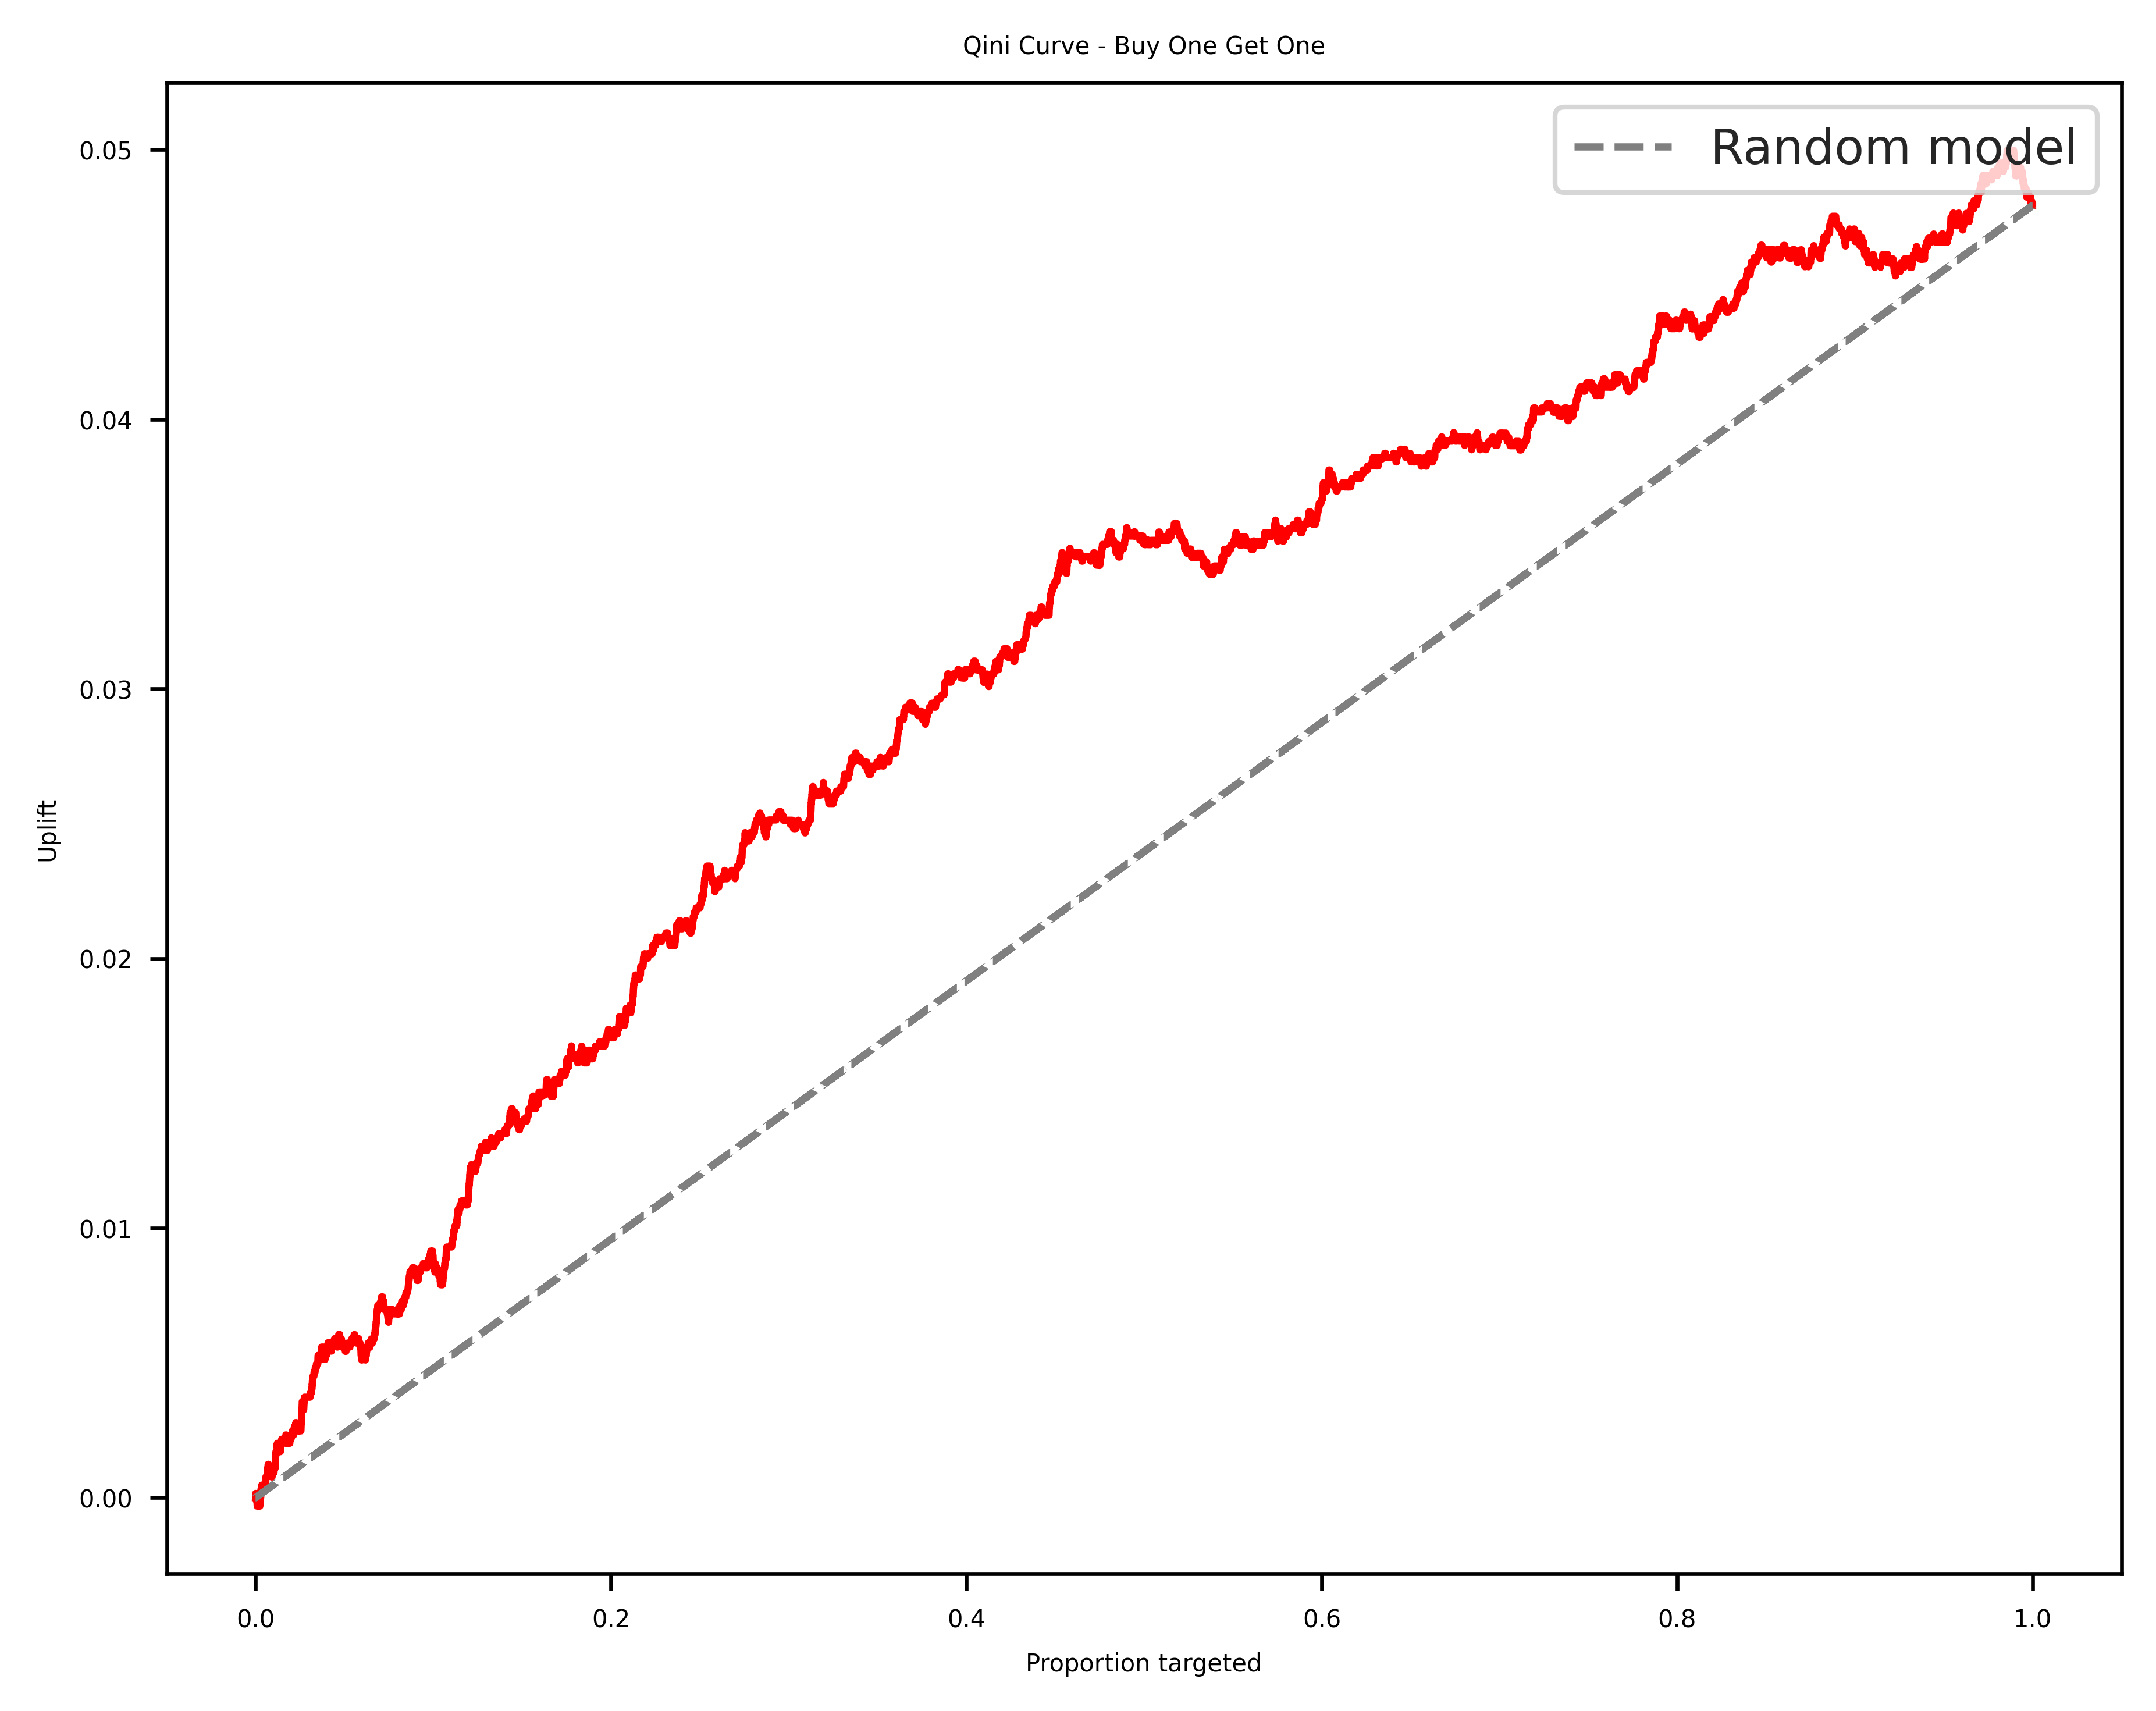

In [83]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=5)

Text(0.5, 1.0, 'Qini Curve - Discount')

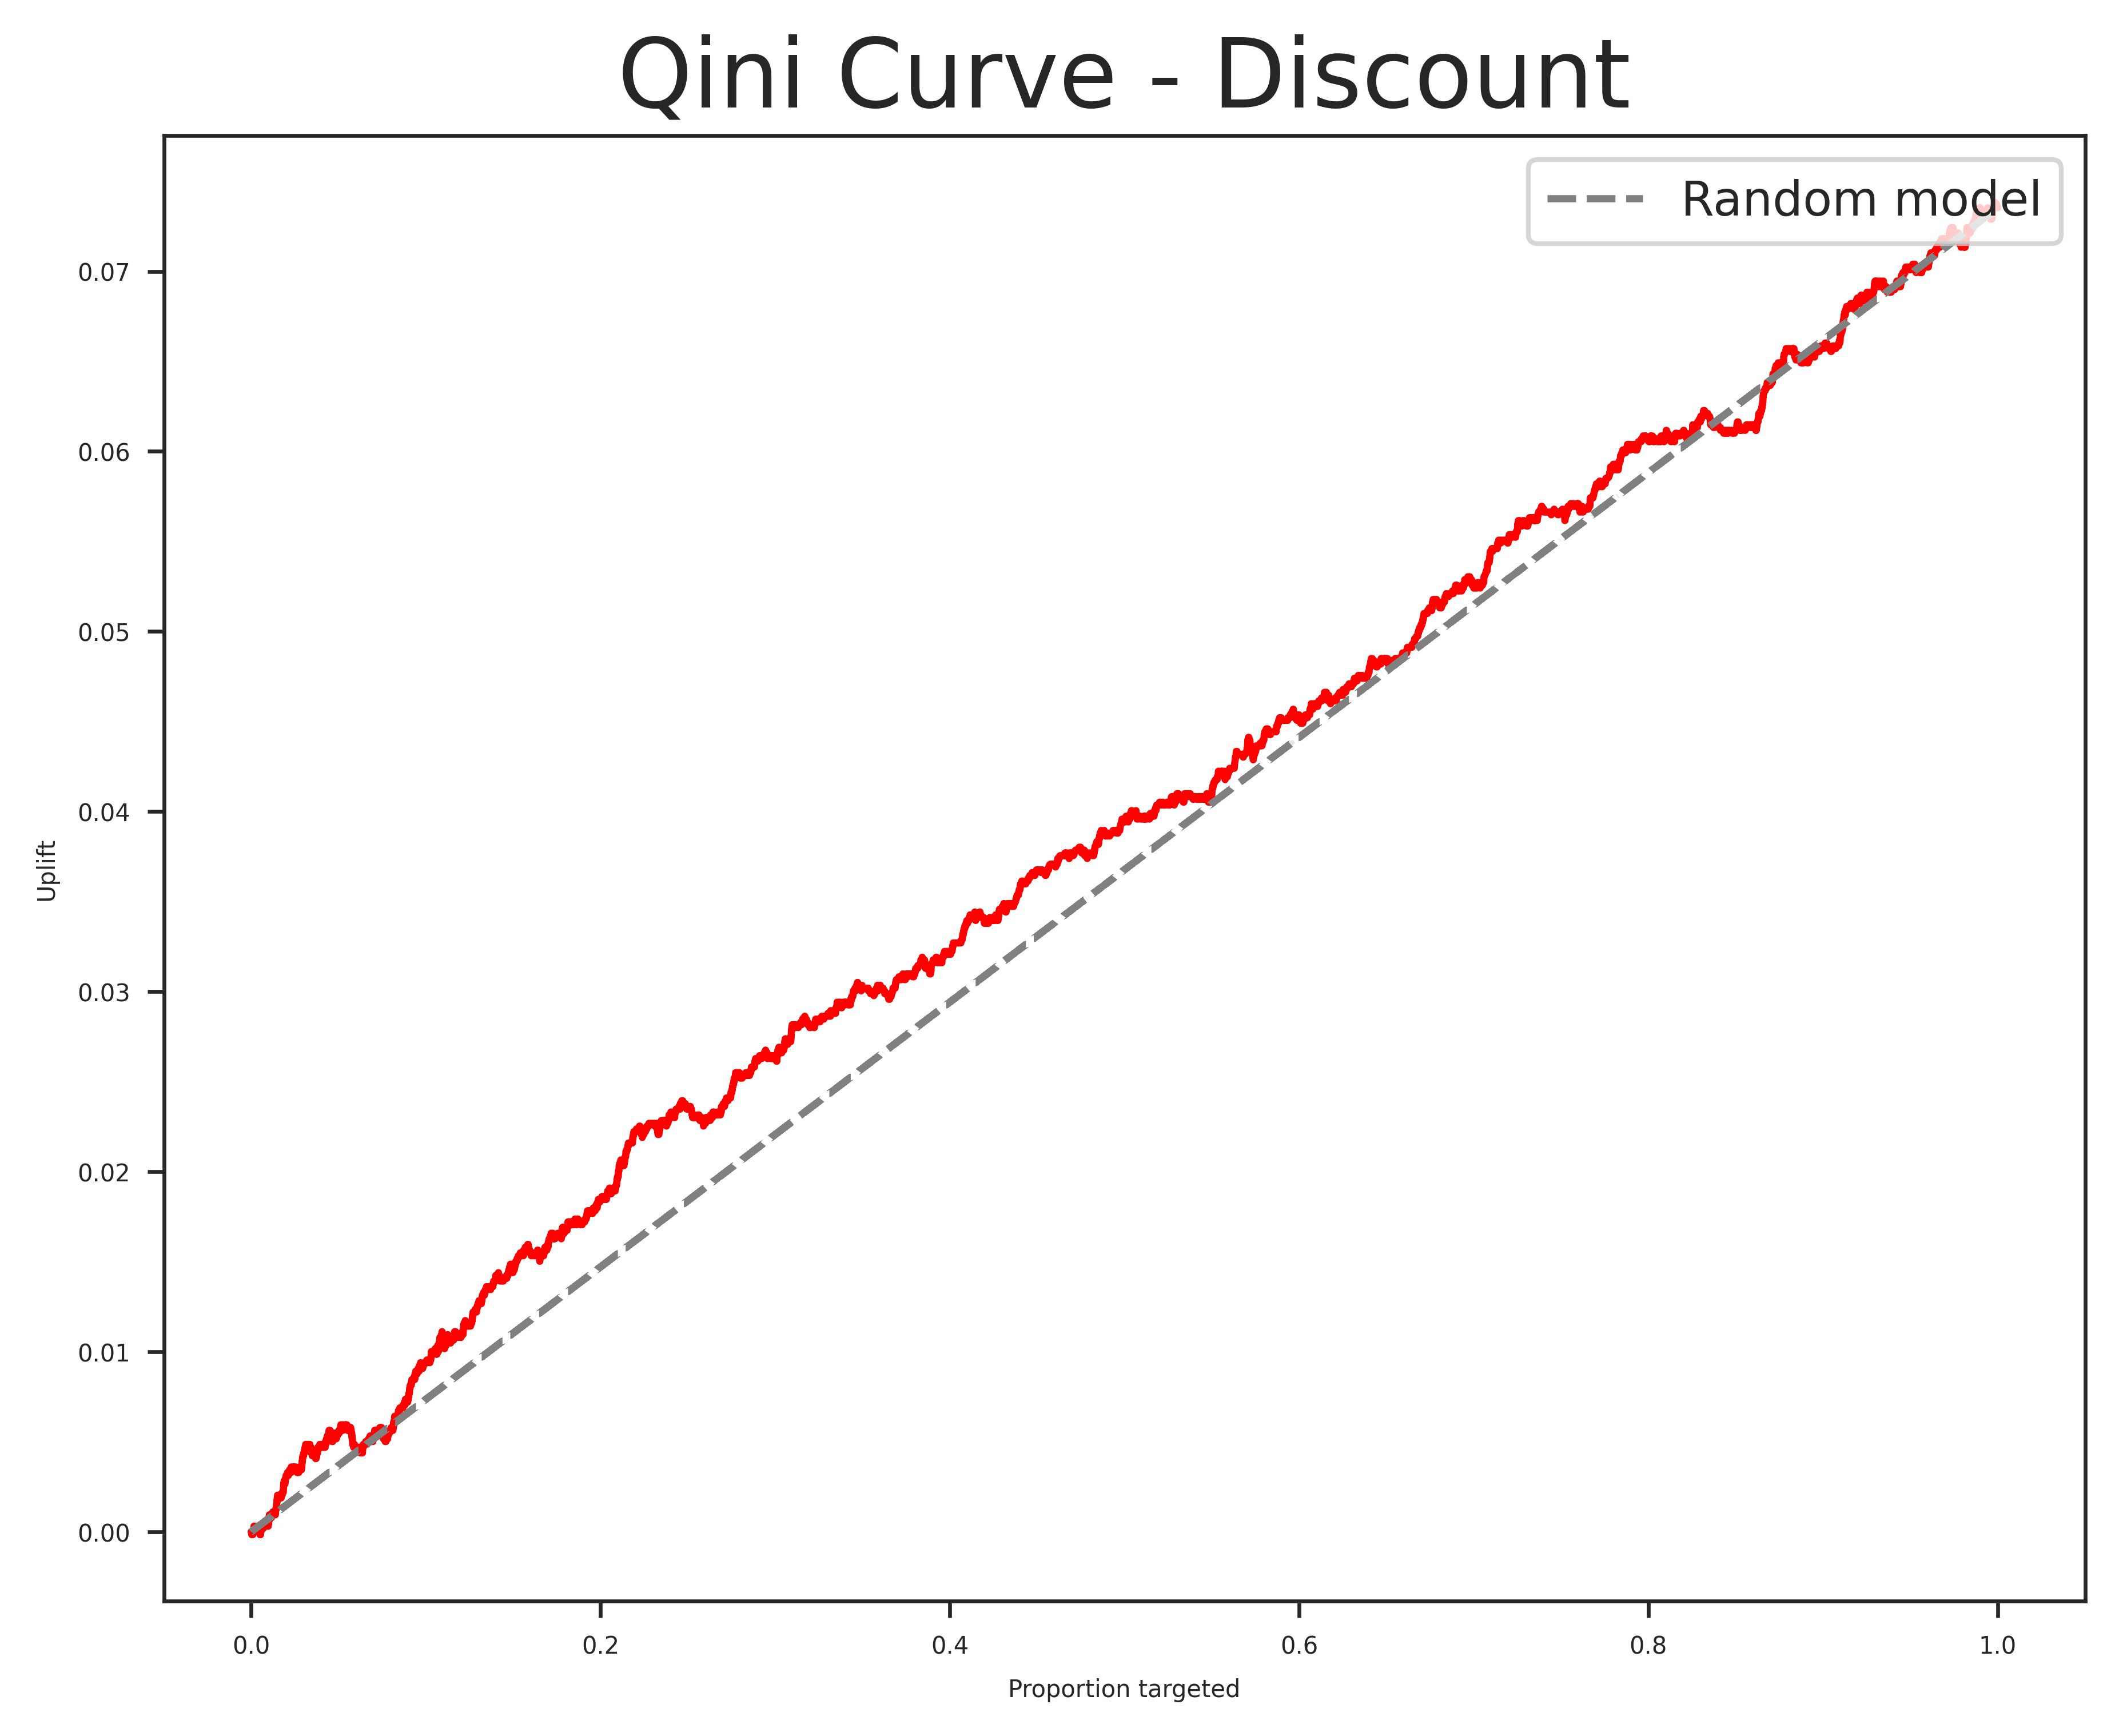

In [84]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)